## General Overview

-------------


The main goal of this research is to build and compare a few models to predict the housing prices in Ames, Iowa(USA). The data is sourced from Kaggle website: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. It contains housing data - 2919 records in total - where 1460 will be used for training purposes and 1459 for testing our models. There are 4 separate files which we are going to use:

- train.csv -> training data in CSV format
- test.csv -> testing data in CSV format
- data_description.txt -> attributes description

Let's start off by importing the necessary modules and reading the file.

In [1]:
# Basic modules for dataframe manipulation
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

# Data Standardization
from sklearn.preprocessing import StandardScaler

# Cross Validaton
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_absolute_error

# Don't display warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read files into a dataframe
df_trainset = pd.read_csv('train.csv', low_memory = False)
df_testset = pd.read_csv('test.csv', low_memory = False)
target = df_trainset['SalePrice']
# Merge training and testing datasets
df_raw = pd.concat([df_trainset.drop('SalePrice', axis = 1), df_testset])
print("Number of records: {}\nNumber of variables: {}".format(df_raw.shape[0], df_raw.shape[1]))

Number of records: 2919
Number of variables: 80


It is important to look at the data first in order to understand its format, structure, value types, number(percentage) of missing data, etc.

In [3]:
# Change the default number of columns displayed by DataFrame's head method
pd.set_option('display.max_columns', 85)

# Display first 5 rows
df_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


As we can see, our dataset consists of various data types: integers, floats, strings so let's check further what are they exact types, but before doing so, we will change column headings to lower case.

In [4]:
# Import 'lower_cols' function from helper module which will convert column headings to lower case
from helper import lower_cols

lower_cols(df_raw)

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
id               2919 non-null int64
mssubclass       2919 non-null int64
mszoning         2915 non-null object
lotfrontage      2433 non-null float64
lotarea          2919 non-null int64
street           2919 non-null object
alley            198 non-null object
lotshape         2919 non-null object
landcontour      2919 non-null object
utilities        2917 non-null object
lotconfig        2919 non-null object
landslope        2919 non-null object
neighborhood     2919 non-null object
condition1       2919 non-null object
condition2       2919 non-null object
bldgtype         2919 non-null object
housestyle       2919 non-null object
overallqual      2919 non-null int64
overallcond      2919 non-null int64
yearbuilt        2919 non-null int64
yearremodadd     2919 non-null int64
roofstyle        2919 non-null object
roofmatl         2919 non-null object
exterior1st      2918 non-

According to the above result, strings representing categorical variables are stored as objects, which is very unefficient due to the increased size and processing time so we will have to convert their data type into "category".

## Data preprocessing


-------------------------------------

Data pre-processing is a critical step that needs to be taken to convert the raw data into a clean data set which is a requirement of the Machine Learning algorithms. The common steps are:

- Cleaning: removal or fixing missing data
- Formatting: adjusting the type of each column and making them suitable for machine learning algorithms


### Cleaning

We have seen above that some variables have missing data which makes them unusable with Machine Learning algorithms. To fix this problem, we have to get rid of variables which have more than 75% of the data missing. For remaining columns, we will apply the following imputation methods: median for continuous variables and mode for categorical ones. Median is usually more preferable to mean, because of negligible impact of outliers.

In [5]:
# Select and print missing values ratio in descending order
missing = df_raw.isnull().sum().sort_values(ascending=False)/len(df_raw)
print(missing)

poolqc           0.996574
miscfeature      0.964029
alley            0.932169
fence            0.804385
fireplacequ      0.486468
lotfrontage      0.166495
garagecond       0.054471
garagequal       0.054471
garageyrblt      0.054471
garagefinish     0.054471
garagetype       0.053786
bsmtcond         0.028092
bsmtexposure     0.028092
bsmtqual         0.027749
bsmtfintype2     0.027407
bsmtfintype1     0.027064
masvnrtype       0.008222
masvnrarea       0.007879
mszoning         0.001370
bsmthalfbath     0.000685
utilities        0.000685
functional       0.000685
bsmtfullbath     0.000685
bsmtfinsf1       0.000343
exterior1st      0.000343
exterior2nd      0.000343
bsmtfinsf2       0.000343
bsmtunfsf        0.000343
totalbsmtsf      0.000343
saletype         0.000343
                   ...   
yearbuilt        0.000000
overallcond      0.000000
salecondition    0.000000
heating          0.000000
exterqual        0.000000
extercond        0.000000
yrsold           0.000000
mosold      

In [6]:
# Copy all columns containing less then 75% of missing values to new variable: 'df
df = df_raw.loc[:, missing < 0.75]

### Formatting

In this section, we are going to convert object data types into category, impute missing values and take a closer look at all variables. Instead of iterating through all variables individually, we will work on certain data types using for loops to ease and speed up the whole process - this will be handled by functions stored in "helper.py" module since converting data and imputing missing values is common in every Data Science - related problem. These actions will result in a clean dataframe object, which then could be used for modelling.

In [7]:
# Import helper functions which are used to speed up the preprocessing
from helper import obj_to_cat, fill_missing_nums, fill_missing_cats

In [8]:
# Convert objects(strings) into category data type
df = obj_to_cat(df)

In [9]:
# Fill missing numerical data with median
df = fill_missing_nums(df)

In [10]:
# Fill missing categorical data with mode
df = fill_missing_cats(df)

# Check if the functions worked as intended
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 76 columns):
id               2919 non-null int64
mssubclass       2919 non-null int64
mszoning         2919 non-null category
lotfrontage      2919 non-null float64
lotarea          2919 non-null int64
street           2919 non-null category
lotshape         2919 non-null category
landcontour      2919 non-null category
utilities        2919 non-null category
lotconfig        2919 non-null category
landslope        2919 non-null category
neighborhood     2919 non-null category
condition1       2919 non-null category
condition2       2919 non-null category
bldgtype         2919 non-null category
housestyle       2919 non-null category
overallqual      2919 non-null int64
overallcond      2919 non-null int64
yearbuilt        2919 non-null int64
yearremodadd     2919 non-null int64
roofstyle        2919 non-null category
roofmatl         2919 non-null category
exterior1st      2919 non-null cate

#### Displaying exemplary columns

In [11]:
# Import 'display_cols' function from helper module to display columns of desired data type
from helper import display_cols

In [12]:
# Display 10 random rows of variables with category data type
display_cols(df, type = 'category', num_samples = 10)

,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfintype2,heating,heatingqc,centralair,electrical,kitchenqual,functional,fireplacequ,garagetype,garagefinish,garagequal,garagecond,paveddrive,saletype,salecondition
1049,RL,Pave,Reg,Low,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
10,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,Hip,CompShg,HdBoard,HdBoard,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Normal
784,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2.5Unf,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Normal
295,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,Po,Detchd,Unf,TA,TA,Y,WD,Normal
376,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,SFoyer,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Normal
1350,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,TA,TA,No,BLQ,LwQ,GasA,TA,Y,SBrkr,TA,Typ,TA,Attchd,Unf,TA,TA,Y,WD,Normal
1364,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,Slab,TA,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,Ex,Attchd,RFn,TA,TA,Y,WD,Normal
909,FV,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,Gable,CompShg,MetalSd,MetalSd,BrkFace,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,Detchd,Unf,TA,TA,Y,WD,Normal
712,RL,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,HdBoard,None,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,WD,Normal
161,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Ex,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,BuiltIn,Fin,TA,TA,Y,WD,Normal


In [13]:
# Display 10 random rows of variables with float data type
display_cols(df, type = 'float', num_samples = 10)

,lotfrontage,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,bsmtfullbath,bsmthalfbath,garageyrblt,garagecars,garagearea
150,120.0,0.0,716.0,0.0,253.0,969.0,0.0,0.0,1975.0,2.0,440.0
802,98.0,146.0,986.0,0.0,163.0,1149.0,1.0,0.0,2005.0,3.0,729.0
719,69.0,0.0,523.0,0.0,448.0,971.0,0.0,0.0,1969.0,1.0,300.0
1444,63.0,106.0,0.0,0.0,1422.0,1422.0,0.0,0.0,2004.0,2.0,626.0
381,60.0,0.0,0.0,0.0,1293.0,1293.0,1.0,0.0,2006.0,2.0,572.0
1108,68.0,0.0,813.0,0.0,675.0,1488.0,0.0,1.0,1968.0,2.0,552.0
1380,68.0,0.0,500.0,0.0,342.0,842.0,0.0,0.0,1999.0,2.0,515.0
1457,66.0,0.0,275.0,0.0,877.0,1152.0,0.0,0.0,1941.0,1.0,252.0
442,52.0,0.0,0.0,0.0,1078.0,1078.0,0.0,0.0,1930.0,2.0,360.0
471,62.0,0.0,330.0,0.0,294.0,624.0,0.0,0.0,2001.0,2.0,440.0


In [14]:
# Display 10 random rows of variables with int64 data type
display_cols(df, type = 'int64', num_samples = 10)

,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold
1427,1428,50,10930,5,6,1945,1950,1048,510,0,1558,1,1,3,1,6,1,0,0,0,0,0,0,0,4,2008
424,425,20,9000,6,5,1956,1956,1196,0,0,1196,1,0,2,1,6,1,0,44,0,0,0,0,0,5,2008
613,614,20,8402,5,5,2007,2007,1120,0,0,1120,1,0,3,1,6,0,0,30,0,0,0,0,0,12,2007
491,1952,20,14450,7,5,1979,1979,1782,0,0,1782,2,0,3,1,6,1,467,0,0,0,0,0,0,3,2008
100,101,20,10603,6,7,1977,2001,1610,0,0,1610,2,0,3,1,6,2,168,68,0,0,0,0,0,2,2010
239,1700,60,9085,7,5,1995,1996,1094,967,0,2061,2,1,3,1,7,1,296,102,209,0,0,0,0,11,2009
674,675,20,9200,6,6,1965,1965,1136,0,0,1136,1,0,3,1,5,1,426,0,0,0,0,0,0,7,2008
498,1959,90,9000,5,5,1974,1974,896,896,0,1792,2,2,4,2,8,0,0,45,0,0,0,0,0,6,2008
749,750,50,8405,4,3,1945,1950,1088,441,0,1529,2,0,4,1,9,0,92,0,185,0,0,0,0,4,2009
692,693,60,26178,7,5,1989,1990,1238,1281,0,2519,2,1,4,1,9,2,320,27,0,0,0,0,0,4,2006


#### Displaying basic statistics of numerical features

In [15]:
# Import 'display_nums_stats' function from helper module to display the basic statistics of numerical columns
from helper import display_nums_stats

display_nums_stats(df)

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,57.137718,69.088386,10168.114080,6.089072,5.564577,1971.312778,1984.264474,101.396026,441.398253,49.565262,560.739979,1051.756252,1159.581706,336.483727,4.694416,1500.759849,0.429599,0.061322,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.161699,1.766701,472.877013,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,842.787043,42.517628,21.317898,7886.996359,1.409947,1.113131,30.291442,20.894344,178.854579,455.534750,169.179104,439.471764,440.692234,392.362079,428.701456,46.396825,506.051045,0.524676,0.245608,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,24.868576,0.761506,215.357944,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,730.500000,20.000000,60.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.500000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2189.500000,70.000000,78.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,163.500000,733.000000,0.000000,805.000000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


Two things that should bring our attention here:

- Id variable is made of ordinal numbers representing an equivalent of dataframe's index + 1 and can be deleted without having any negative impact on our model

- Some values look suspicious hence we need to take a closer look at them and detect the outliers (only these from the 'training' dataset)

In [16]:
# Delete 'Id' column 
df.drop(['id'], axis = 1, inplace = True)

#### Converting some of the nominal numerical variables into categories

In [17]:
# Import 'nominalnums_to_cat' function from helper module
from helper import nominalnums_to_cat

# Convert nominal numerical variables(having less than 30 unique values) into categories and return names of these which have more than 8 unique values for further check
cats_to_verify = nominalnums_to_cat(df, unique_values_split = 30, boundary = 8)

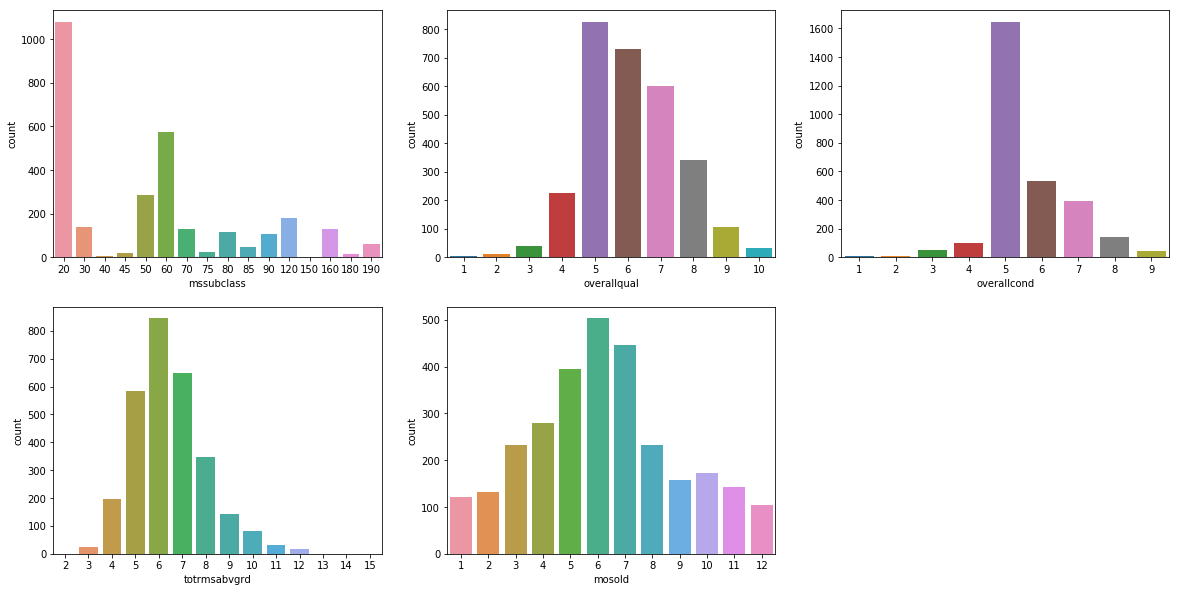

In [18]:
# Import 'plot_categoricals' function from helper module
from helper import plot_categoricals

# Display count plots for columns returned by 'nominalnums_to_cat' function to verify their values 
plot_categoricals(df, cats_to_verify, kind = 'count')

In the above charts we can see that most of the houses have 4 to 9 rooms and overall quality and condition scores between 5 to 8. Also, it's worth pointing out that most of the houses were sold between March and August. This should not be surprising, as it is much easier to relocate when the weather conditions are more favorable. According to the 'mssubclass' attribute, most of the houses are 1 and 2-story buildings built in 1946 or later. 

#### Looking for outliers using Tukey's Interquartile Range 

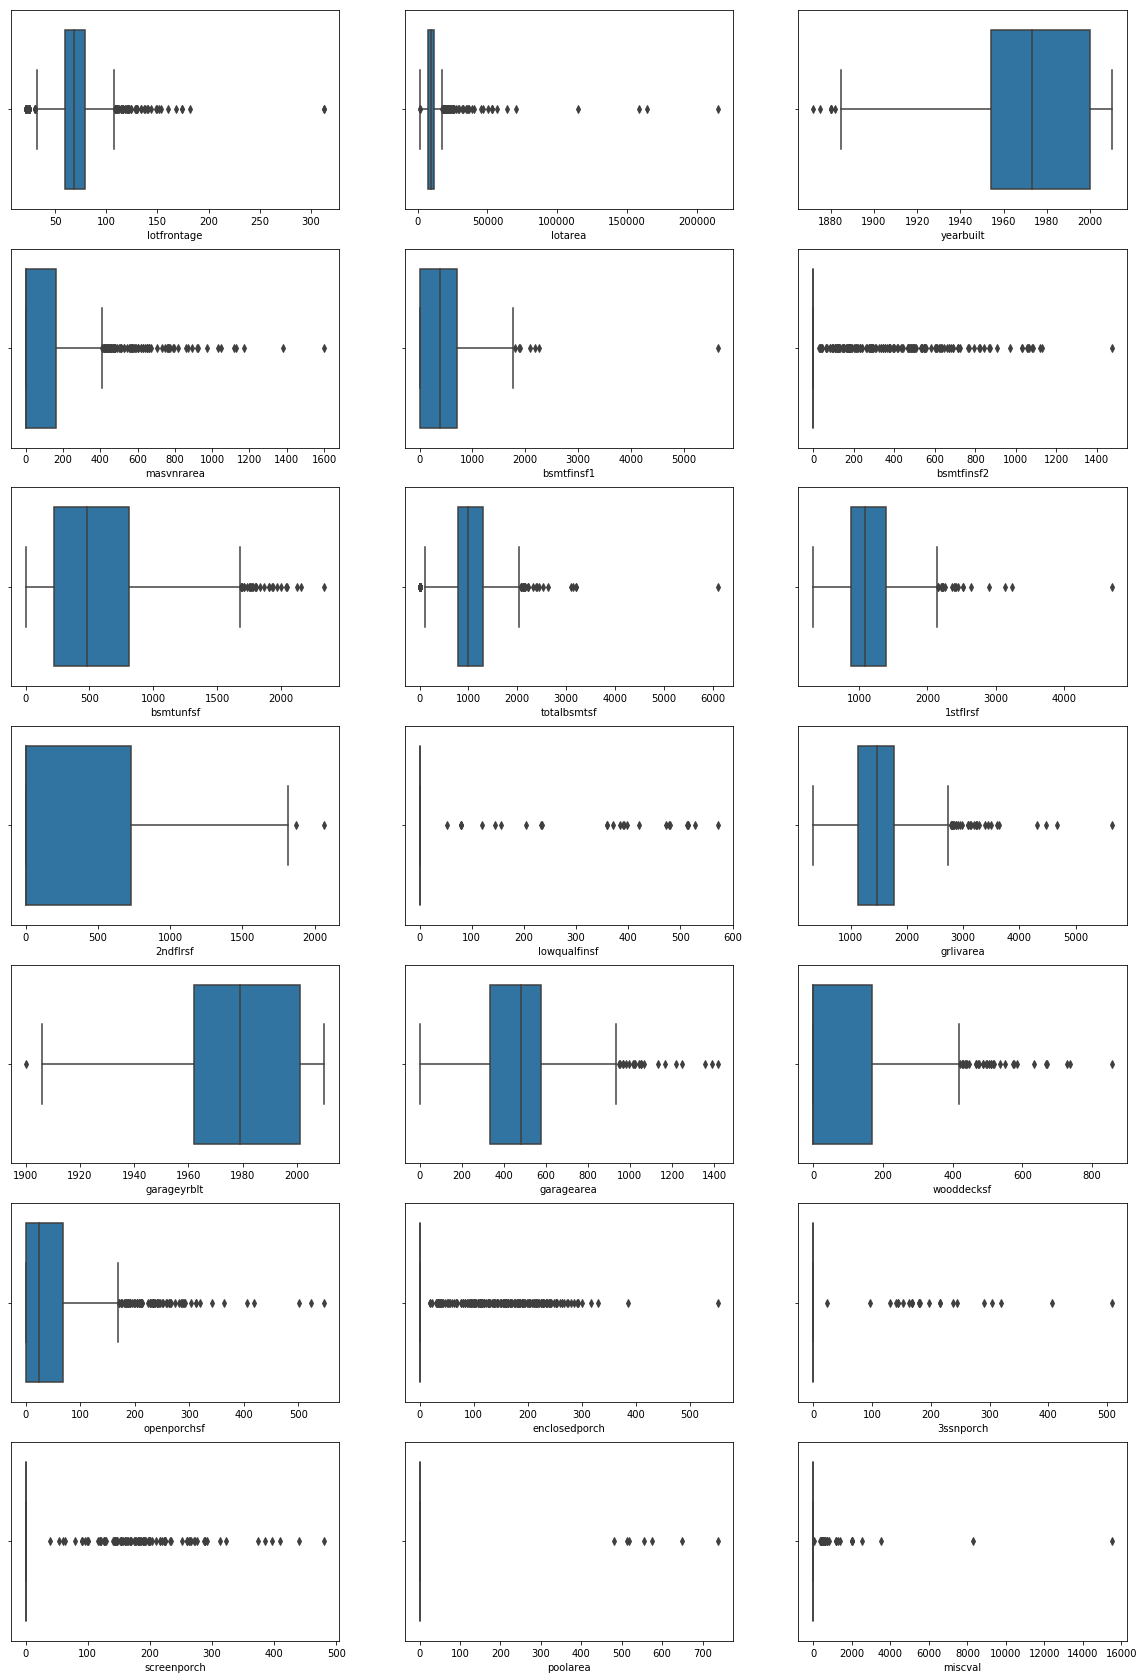

In [19]:
# Import 'outliers_by_col' function from helper module to find outliers in numerical columns( based on Tukey's Interquartile Range ). We are looking for outliers only in the training set as it will be used for training our models. Function will plot box plots for suspicious columns.
from helper import outliers_by_col

trn_last_idx = 1460

outliers = outliers_by_col(df, trn_last_idx , multiplier = 1.5, plot_results = True, outliers_dictionary = False)

Looking at the box plots it's difficult to say whether observations denoted as outliers are real outliers hence I decided to leave them in our training set and use for modelling. Distributions of some variables are very unequal, so I think that it would be better to convert them into binomial categorical variables. These include :

- bsmtfinsf2 
- lowqualfinsf 
- poolarea
- screenporch
- miscval
- 3ssnporch
- enclosedporch

#### Binarizing numerical variables where most of the observations have zeroed values

In [20]:
# Import 'binarize_numericals' function from helper module which will create binomial categorical equivalents of the input variables, values = 0  will be denoted as 0 and values > 0  will be marked as 1
from helper import binarize_numericals

cols_to_binarize = ['bsmtfinsf2', 'lowqualfinsf', 'poolarea', 'screenporch', 'miscval', '3ssnporch', 'enclosedporch']
binarize_numericals(df, cols_to_binarize)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 75 columns):
mssubclass           2919 non-null category
mszoning             2919 non-null category
lotfrontage          2919 non-null float64
lotarea              2919 non-null int64
street               2919 non-null category
lotshape             2919 non-null category
landcontour          2919 non-null category
utilities            2919 non-null category
lotconfig            2919 non-null category
landslope            2919 non-null category
neighborhood         2919 non-null category
condition1           2919 non-null category
condition2           2919 non-null category
bldgtype             2919 non-null category
housestyle           2919 non-null category
overallqual          2919 non-null category
overallcond          2919 non-null category
yearbuilt            2919 non-null int64
yearremodadd         2919 non-null int64
roofstyle            2919 non-null category
roofmatl             29

Now we are left with 60 categorical and 15 numerical variables. Since in this notebook we are going to use advanced regression techniques: Random Forests and Extreme Gradient Boosted Trees, we don't need to standarize the values of numerical variables as these Machine Learning alogorithms are not distance based hence resilient to the differences in measurement scales. Also, they will help us to find the most important explanatory variables. Before modelling we need to convert values of categorical features into numbers.

#### Converting values of categorical features into numbers

In [22]:
#Import 'get_codes' function from helper module to convert values of categorical variables into numbers
from helper import get_codes

get_codes(df)
df.head()

,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,mosold,yrsold,saletype,salecondition,bsmtfinsf2_bin,lowqualfinsf_bin,poolarea_bin,screenporch_bin,miscval_bin,3ssnporch_bin,enclosedporch_bin
0,5,3,65.0,8450,1,3,3,0,4,0,5,2,2,0,5,6,4,2003,2003,1,1,12,13,1,196.0,2,4,2,2,3,3,2,706.0,5,150.0,856.0,1,0,1,4,856,854,1710,1,0,2,1,3,1,2,6,6,0,2,1,2003.0,1,2,548.0,4,4,2,0,61,1,2,8,4,0,0,0,0,0,0,0
1,0,3,80.0,9600,1,3,3,0,2,0,24,1,2,0,2,5,7,1976,1976,1,1,8,8,2,0.0,3,4,1,2,3,1,0,978.0,5,284.0,1262.0,1,0,1,4,1262,0,1262,0,1,2,0,3,1,3,4,6,1,4,1,1976.0,1,2,460.0,4,4,2,298,0,4,1,8,4,0,0,0,0,0,0,0
2,5,3,68.0,11250,1,0,3,0,4,0,5,2,2,0,5,6,4,2001,2002,1,1,12,13,1,162.0,2,4,2,2,3,2,2,486.0,5,434.0,920.0,1,0,1,4,920,866,1786,1,0,2,1,3,1,2,4,6,1,4,1,2001.0,1,2,608.0,4,4,2,0,42,8,2,8,4,0,0,0,0,0,0,0
3,6,3,60.0,9550,1,0,3,0,0,0,6,2,2,0,5,6,4,1915,1970,1,1,13,15,2,0.0,3,4,0,3,1,3,0,216.0,5,540.0,756.0,1,2,1,4,961,756,1717,1,0,1,0,3,1,2,5,6,1,2,5,1998.0,2,3,642.0,4,4,2,0,35,1,0,8,0,0,0,0,0,0,0,1
4,5,3,84.0,14260,1,0,3,0,2,0,15,2,2,0,5,7,4,2000,2000,1,1,12,13,1,350.0,2,4,2,2,3,0,2,655.0,5,490.0,1145.0,1,0,1,4,1145,1053,2198,1,0,2,1,4,1,2,7,6,1,4,1,2000.0,1,3,836.0,4,4,2,192,84,11,2,8,4,0,0,0,0,0,0,0


#### Dividing the dataset into training, validation and testing subsets

In [23]:
# We excluded the target variable - SalePrice - at the very beginning so now we only have to divide our dataframe into training and testing sets
df_train = df[:trn_last_idx]
df_test = df[trn_last_idx:]

# Assign the dependent variable into a separate variable
y = np.log(target)


# Create train and validation sets from the training subset
X_train, X_val, y_train, y_val = train_test_split(df_train, y, test_size = 0.2, random_state = 123, shuffle = False)

## Metrics

It is crucial for every Machine Learing project to select an appropriate metric used for validating the predictions. In this competition all submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price meaning that in result we are going to measure the results using Root-Mean-Squared-Logarithmic-Error(RMSLE). Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

## Machine Learning

We are well prepared now for an endeavour to create a robust and accurate predictive model.

### Random Forests

It is a sort of universal Machine Learning technique, a way of predicting something that could be of any kind - category or continuous variable (like in this competition - price). In general, it does not overfit too badly and it is not hard to stop it from overfitting. It has few (if any) statistical assumptions. It does not assume that given data is normally distributed, standarized, relationships are linear, or that interactions have been specified. It requires relatively few feature engineering, like for example taking 'log' or 'exp' of the data.

Random Forest algorithm is based on bagging trees. The idea of bagging is to create a couple of subsets of data and use them to train the model. For example imagine as if we created five different models, each of which was only somewhat predictive, but the models were not correlated with each other. Five models would have a different insight into the relationships of the data. If we took average of them, we end up with the ensemble of different models. The number of said models can be set using n_estimators hyperparameter.

Random Forest is not so easy to explain due to higher complexity. However, there are some tools making it possible like the 'plot_feat_imp' function from the helper module which can be harnessed to point out the most important features that influence the performance of our model.

#### Training initial models

In [24]:
# Import print_score function from helper module to assess the model's performance
from helper import print_score


# Simple Random Forest model
simple_RF = RandomForestRegressor(n_jobs = -1, random_state = 123)
%time simple_RF.fit(X_train, y_train)
print_score(simple_RF,X_train, X_val, y_train, y_val, scoring_func = 'rmsle')

Wall time: 110 ms
Training RMSLE: 0.176 | Testing RMSLE: 0.198 | Training R^2: 0.973 | Testing R^2: 0.850


In [25]:
# Increase the number of estimators
tuned_RF = RandomForestRegressor(n_estimators = 40, n_jobs = -1, random_state = 123)
%time tuned_RF.fit(X_train, y_train)
print_score(tuned_RF, X_train, X_val, y_train, y_val, scoring_func = 'rmsle')

Wall time: 243 ms
Training RMSLE: 0.143 | Testing RMSLE: 0.189 | Training R^2: 0.982 | Testing R^2: 0.863


As we can see, the results of our models are promising, it's worth emphasizing the fact that increasing the number of estimators - trees - used in our Random Forest model reduced the RMSLE and increased the coefficient of determination R^2 meaning that the model was able to explain greater part of change in the target variable - Sale Price. Now, let's try to apply a very computational costly grid search object that will help us obtain the optimum hyperparameters. 

#### Hyperparameter tuning using GridSearchCV

In [26]:
# Import 'make_scorer' and 'rmsle' functions from scikit-learn and helper module respectively and create our own scorer for GridSearchCV object
from sklearn.metrics import make_scorer
from helper import rmsle

scorer = make_scorer(rmsle, greater_is_better=False)

# Select hyperparameters for testing
param_grid = { 
    'max_features': [0.5, 'sqrt', 'log2', 'auto'],
    'max_depth': [None, 8, 10, 12],
    'min_samples_leaf': [1, 3, 5],
    'n_estimators': [40]
}


cv_RF = GridSearchCV(RandomForestRegressor(random_state = 123), param_grid = param_grid, cv = 5, scoring = scorer, n_jobs = -1)
%time cv_RF.fit(X_train, y_train)

Wall time: 20.4 s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [0.5, 'sqrt', 'log2', 'auto'], 'max_depth': [None, 8, 10, 12], 'min_samples_leaf': [1, 3, 5], 'n_estimators': [40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=0)

In [27]:
# Show the best parameters
cv_RF.best_params_

{'max_depth': None,
 'max_features': 0.5,
 'min_samples_leaf': 1,
 'n_estimators': 40}

Since the optimal parameters are known, let's stick to them in further experiments.

In [28]:
# Increase the number of estimators
gs_tuned_RF = RandomForestRegressor(n_estimators = 40, max_features = 0.5, min_samples_leaf = 1,  n_jobs = -1, random_state = 123)
%time gs_tuned_RF.fit(X_train, y_train)
print_score(gs_tuned_RF, X_train, X_val, y_train, y_val, scoring_func = 'rmsle')

Wall time: 126 ms
Training RMSLE: 0.140 | Testing RMSLE: 0.192 | Training R^2: 0.983 | Testing R^2: 0.860


Once optimum hyperparameters have been chosen, we should take a look at feature importance graph. Typically, Random Forest chooses a few dominant features that strongly impact the overall result. It is worth to check what could happen if we deleted one (or more) of those dominant features. There might be some relations occurring and breaking them can bring some positive results. Before doing so, let's plot feature importances and build a model using only the best 15 features found by Random Forest Regressor.

#### Finding most predictive features

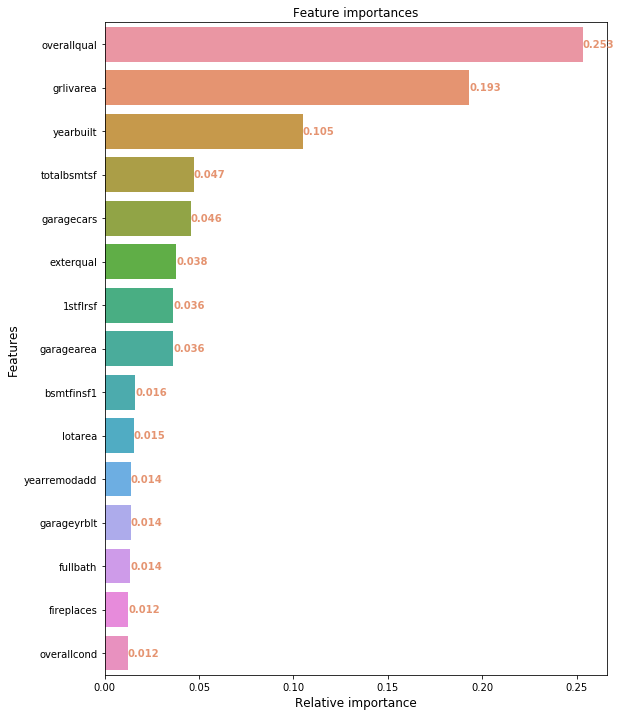

In [29]:
# Import 'plot_feat_imp' function from helper module to plot the feature importances found by Random Forest Regressor
from helper import plot_feat_imp

# Display feature importances and return names of best features  
best_features_list = plot_feat_imp(gs_tuned_RF, df, boundary = 15, best_features = True)

In [30]:
# Dataframe with best 15 features + some which might my useful for further feature engineering
subjectives = ['neighborhood', 'mosold', 'yrsold']
df_train2 = pd.concat([df_train[best_features_list], df_train[subjectives]], axis = 1)

# Dividing the dataframe into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df_train2, y, test_size = 0.2, random_state = 123, shuffle = False)

tuned_RF = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 1, max_features = 0.5, n_jobs = -1, random_state = 123)
%time tuned_RF.fit(X_train, y_train)
print_score(tuned_RF, X_train, X_val, y_train, y_val, scoring_func = 'rmsle')

Wall time: 126 ms
Training RMSLE: 0.139 | Testing RMSLE: 0.198 | Training R^2: 0.983 | Testing R^2: 0.852


Removing less predictive features from the training data reduced the RMSLE and increased R^2 on both training and validation sets but leaving <i>neighborhood</i>, <i>mosold</i> and <i>yrsold</i> variables caused the opposite. Now let's check if we could receive even better scores after removing one of the best features.  

In [31]:
# Import 'drop_best_feats' function from helper module which will iterate over a list of passed features, build models without each of them and assess their performance
from helper import drop_best_feats

drop_best_feats(tuned_RF, best_features_list, df_train2, y, scoring_func = 'rmsle')

Dropped feature: overallqual 
Training RMSLE: 0.142 | Testing RMSLE: 0.193 | Training R^2: 0.982 | Testing R^2: 0.859


Dropped feature: grlivarea 
Training RMSLE: 0.152 | Testing RMSLE: 0.204 | Training R^2: 0.980 | Testing R^2: 0.843


Dropped feature: yearbuilt 
Training RMSLE: 0.145 | Testing RMSLE: 0.198 | Training R^2: 0.982 | Testing R^2: 0.852


Dropped feature: totalbsmtsf 
Training RMSLE: 0.139 | Testing RMSLE: 0.194 | Training R^2: 0.983 | Testing R^2: 0.857


Dropped feature: garagecars 
Training RMSLE: 0.140 | Testing RMSLE: 0.194 | Training R^2: 0.983 | Testing R^2: 0.857


Dropped feature: exterqual 
Training RMSLE: 0.141 | Testing RMSLE: 0.195 | Training R^2: 0.983 | Testing R^2: 0.856


Dropped feature: 1stflrsf 
Training RMSLE: 0.141 | Testing RMSLE: 0.188 | Training R^2: 0.983 | Testing R^2: 0.867


Dropped feature: garagearea 
Training RMSLE: 0.139 | Testing RMSLE: 0.189 | Training R^2: 0.983 | Testing R^2: 0.865


Dropped feature: bsmtfinsf1 
Training RMSLE: 0.146 

Going towards building last Random Forest Regressor, we will remove one more feature from our dataset - <i>fullbath</i> - as without this variable our model achieves best generalization performance.

In [32]:
df_train3 = df_train2.drop('fullbath', axis=1)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(df_train3, y, test_size = 0.2, random_state = 123, shuffle = False)
X_test = df_test[df_train3.columns]

X_test.head()

,overallqual,grlivarea,yearbuilt,totalbsmtsf,garagecars,exterqual,1stflrsf,garagearea,bsmtfinsf1,lotarea,yearremodadd,garageyrblt,fireplaces,overallcond,neighborhood,mosold,yrsold
0,4,896,1961,882.0,1,3,896,730.0,468.0,11622,1961,1961.0,0,5,12,5,4
1,5,1329,1958,1329.0,1,3,1329,312.0,923.0,14267,1958,1958.0,0,5,12,5,4
2,4,1629,1997,928.0,2,3,928,482.0,791.0,13830,1998,1997.0,1,4,8,2,4
3,5,1604,1998,926.0,2,3,926,470.0,602.0,9978,1998,1998.0,1,5,8,5,4
4,7,1280,1992,1280.0,2,2,1280,506.0,263.0,5005,1992,1992.0,0,4,22,0,4


In [34]:
# Train the model and present results
tuned_RF = RandomForestRegressor(n_estimators = 300, min_samples_leaf = 1, max_features = 0.5, n_jobs = -1, random_state = 123)
%time tuned_RF.fit(X_train, y_train)
print_score(tuned_RF, X_train, X_val, y_train, y_val, scoring_func = 'rmsle')

Wall time: 488 ms
Training RMSLE: 0.137 | Testing RMSLE: 0.186 | Training R^2: 0.984 | Testing R^2: 0.870


#### Creating first submission file

In [35]:
tuned_RF_pred = tuned_RF.predict(X_test)
rf_sub = pd.DataFrame([df_testset['Id'], np.exp(tuned_RF_pred)],).T
rf_sub.columns = ['Id','SalePrice']
rf_sub['Id'] = rf_sub['Id'].astype(int)
rf_sub.to_csv('submissions/rf_sub.csv', index = False)

## Feature Engineering

In [36]:
df = pd.concat([df_train3, df_test[df_train3.columns]], axis = 0)

In [37]:
df.head()

,overallqual,grlivarea,yearbuilt,totalbsmtsf,garagecars,exterqual,1stflrsf,garagearea,bsmtfinsf1,lotarea,yearremodadd,garageyrblt,fireplaces,overallcond,neighborhood,mosold,yrsold
0,6,1710,2003,856.0,2,2,856,548.0,706.0,8450,2003,2003.0,0,4,5,1,2
1,5,1262,1976,1262.0,2,3,1262,460.0,978.0,9600,1976,1976.0,1,7,24,4,1
2,6,1786,2001,920.0,2,2,920,608.0,486.0,11250,2002,2001.0,1,4,5,8,2
3,6,1717,1915,756.0,3,3,961,642.0,216.0,9550,1970,1998.0,1,4,6,1,0
4,7,2198,2000,1145.0,3,2,1145,836.0,655.0,14260,2000,2000.0,1,4,15,11,2


#### Discretizing numerical variables

In this section we will create new features out of the currently available ones. Since our numerical features take in multiple values we can discretize them to create equally distributed bins.  

In [38]:
df['year_built'] = pd.cut(df['yearbuilt'], 25 , precision= 0, right = False)
df['grliv_area'] = pd.cut(df['grlivarea'], 50, precision = 0, right = False)
df['1stflr_sf'] = pd.cut(df['1stflrsf'], 50, precision = 0, right = False)
df['totalbsmt_sf'] = pd.cut(df['totalbsmtsf'], 50, precision = 0 , right = False)
df['garage_area'] = pd.cut(df['garagearea'], 50, precision = 0, right = False)
df['bsmtfin_sf1'] = pd.cut(df['bsmtfinsf1'], 70, precision = 0, right = False)
df['lot_area'] = pd.cut(df['lotarea'], 150, precision = 0 ,right = False)
df['garageyr_blt'] = pd.cut(df['garageyrblt'], 100, precision = 0, right = False)

df = df.drop(['yearbuilt', 'grlivarea','1stflrsf','totalbsmtsf','garagearea','bsmtfinsf1','lotarea','garageyrblt'], axis = 1)

In [39]:
# Replacing values of newly created, discretized features with numbers 
get_codes(df)
df.head()

,overallqual,garagecars,exterqual,yearremodadd,fireplaces,overallcond,neighborhood,mosold,yrsold,year_built,grliv_area,1stflr_sf,totalbsmt_sf,garage_area,bsmtfin_sf1,lot_area,garageyr_blt
0,6,2,2,2003,0,4,5,1,2,23,12,5,7,18,8,5,34
1,5,2,3,1976,1,7,24,4,1,18,8,9,10,15,12,5,25
2,6,2,2,2002,1,4,5,8,2,23,13,6,7,20,6,6,33
3,6,3,3,1970,1,4,6,1,0,7,13,6,6,21,2,5,33
4,7,3,2,2000,1,4,15,11,2,23,17,8,9,28,8,9,33


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 17 columns):
overallqual     2919 non-null int8
garagecars      2919 non-null int8
exterqual       2919 non-null int8
yearremodadd    2919 non-null int64
fireplaces      2919 non-null int8
overallcond     2919 non-null int8
neighborhood    2919 non-null int8
mosold          2919 non-null int8
yrsold          2919 non-null int8
year_built      2919 non-null int8
grliv_area      2919 non-null int8
1stflr_sf       2919 non-null int8
totalbsmt_sf    2919 non-null int8
garage_area     2919 non-null int8
bsmtfin_sf1     2919 non-null int8
lot_area        2919 non-null int16
garageyr_blt    2919 non-null int8
dtypes: int16(1), int64(1), int8(15)
memory usage: 94.1 KB


#### Creating new features

In this section we are going to create new features representing mean and median house price by overall quality, neighboorhood, year and month sold respectively. Since sale price is known only for the training subset, we will create new dataframe <i>df_feng</i> which we will use to calculate abovely mentioned statistics.

In [41]:
df_feng = pd.concat([df_train3, target], axis = 1)

columns = ['overallqual', 'neighborhood', 'yrsold', 'mosold'] 
for col in columns:
    col_mean = dict(df_feng.groupby(col)['SalePrice'].mean())
    df['mean_prc_by_'+col[:4]] = df[col].map(col_mean)

In [42]:
df.head()

,overallqual,garagecars,exterqual,yearremodadd,fireplaces,overallcond,neighborhood,mosold,yrsold,year_built,grliv_area,1stflr_sf,totalbsmt_sf,garage_area,bsmtfin_sf1,lot_area,garageyr_blt,mean_prc_by_over,mean_prc_by_neig,mean_prc_by_yrso,mean_prc_by_moso
0,6,2,2,2003,0,4,5,1,2,23,12,5,7,18,8,5,34,207716.423197,197965.773333,177360.838816,177882.000000
1,5,2,3,1976,1,7,24,4,1,18,8,9,10,15,12,5,25,161603.034759,238772.727273,186063.151976,172307.269608
2,6,2,2,2002,1,4,5,8,2,23,13,6,7,20,6,6,33,207716.423197,197965.773333,177360.838816,195683.206349
3,6,3,3,1970,1,4,6,1,0,7,13,6,6,21,2,5,33,207716.423197,210624.725490,182549.458599,177882.000000
4,7,3,2,2000,1,4,15,11,2,23,17,8,9,28,8,9,33,274735.535714,335295.317073,177360.838816,186518.966102


## Machine Learning part 2

#### Building final Random Forest Regressor

In [43]:
df_train = df[:trn_last_idx]
df_test = df[trn_last_idx:]

X_train, X_val, y_train, y_val = train_test_split(df_train, y, test_size = 0.2, random_state = 123, shuffle = False)

In [44]:
# Train the model and present results
final_RF = RandomForestRegressor(n_estimators = 300, min_samples_leaf = 1, max_features = 0.5, n_jobs = -1, random_state = 123)
%time final_RF.fit(X_train, y_train)
print_score(final_RF, X_train, X_val, y_train, y_val, scoring_func = 'rmsle')

Wall time: 482 ms
Training RMSLE: 0.136 | Testing RMSLE: 0.187 | Training R^2: 0.984 | Testing R^2: 0.868


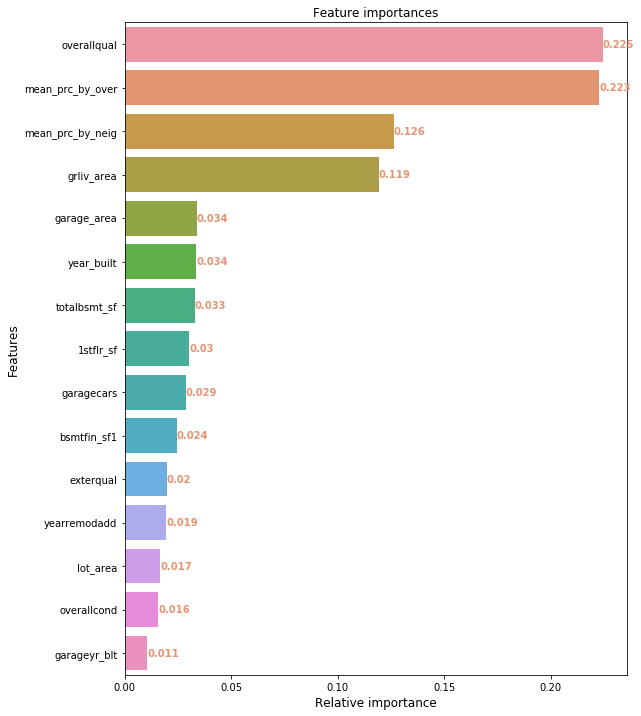

In [45]:
best_features_list = plot_feat_imp(final_RF, df, boundary = 15, best_features = True)

In [46]:
df = df[best_features_list]
df_train = df[:trn_last_idx]
df_test = df[trn_last_idx:]

X_train, X_val, y_train, y_val = train_test_split(df_train, y, test_size = 0.2, random_state = 123, shuffle = False)

In [47]:
df_train.head()

,overallqual,mean_prc_by_over,mean_prc_by_neig,grliv_area,garage_area,year_built,totalbsmt_sf,1stflr_sf,garagecars,bsmtfin_sf1,exterqual,yearremodadd,lot_area,overallcond,garageyr_blt
0,6,207716.423197,197965.773333,12,18,23,7,5,2,8,2,2003,5,4,34
1,5,161603.034759,238772.727273,8,15,18,10,9,2,12,3,1976,5,7,25
2,6,207716.423197,197965.773333,13,20,23,7,6,2,6,2,2002,6,4,33
3,6,207716.423197,210624.725490,13,21,7,6,6,3,2,3,1970,5,4,33
4,7,274735.535714,335295.317073,17,28,23,9,8,3,8,2,2000,9,4,33


### XGBoost

XGBoost is sometimes named as 'an ultimate weapon of a data scientist'. It is a powerful algorithm, which very often rises to heights of any predictive model. A vast majority of data competitions are won by XGB experts. It is a versatile and sophisticated technique, which is relatively fast (given its complexity) and produces outstanding results. Random Forest did a really good job in solving our problem, but we may expect even more from XGB!

In [48]:
# Instantiate parameters for grid search
param_grid_xgb = {
    'max_depth': [4, 5, 6, 7],
    'min_child_weight': range(1, 6, 1),
    'gamma': [0.0, 0.05, 0.1, 0.2],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
}

In [49]:
# Check all possible combinations of hyperparameters
cv_XGB = GridSearchCV(estimator=XGBRegressor(n_estimators = 40, subsample = 0.5, objective = 'reg:linear', n_jobs = -1, seed = 123), 
            param_grid = param_grid_xgb, scoring = scorer, cv = 5, n_jobs = -1)

%time cv_XGB.fit(X_train, y_train)
cv_XGB.best_params_, cv_XGB.best_score_

Wall time: 4min 55s


({'gamma': 0.0,
  'learning_rate': 0.15,
  'max_depth': 7,
  'min_child_weight': 4,
  'reg_alpha': 0.001},
 -0.15936220095935127)

Now as we know the optimal hyperparameters, it's time for building the final XGBoost Regressor-based model 

#### Building final XGBoost Regressor-based Model

In [50]:
# Train final XGB model
final_XGBR = XGBRegressor(learning_rate = 0.2, n_estimators = 300, max_depth = 6, min_child_weight = 2, gamma = 0.05,
             subsample = 0.8, objective = 'reg:linear', n_jobs = -1, seed = 123, reg_alpha = 0.001)
%time final_XGBR.fit(X_train, y_train)
print_score(final_XGBR, X_train, X_val, y_train, y_val, scoring_func = 'rmsle')

Wall time: 378 ms
Training RMSLE: 0.183 | Testing RMSLE: 0.164 | Training R^2: 0.970 | Testing R^2: 0.899


In [51]:
final_XGBR_pred = final_XGBR.predict(df_test)
xgbr_sub = pd.DataFrame([df_testset['Id'], np.exp(final_XGBR_pred)],).T
xgbr_sub.columns = ['Id','SalePrice']
xgbr_sub['Id'] = xgbr_sub['Id'].astype(int)
xgbr_sub.to_csv('submissions/xgbr_sub.csv', index = False)